# Project One - Working with NHANES Dataset

Selected variables were selected from NHANES dataset from 2015-2016. The data contains information on the following components.
1) Life style factors - Smoking, Drinking
2) Anthropometric measurements 
3) Blood pressure profile
4) Subjects' Profile - Ethnicity, No. of Household member, Income ratio, Insurance coverage, Marital Status, Age and Education Level

For simplified analysis, subjects with NA observed will be dropped.


References
Public Dataset - NHANES dataset and Codebook can be found (here)[https://wwwn.cdc.gov/nchs/nhanes/search/default.aspx]

## Importing packages

In [65]:
import matplotlib.pyplot as plt # for plotting
import pandas as pd # for wrangling data
import numpy as np # managing numbers
import seaborn as sns

## Importing and Reading Dataset


In [103]:
df= pd.read_csv("https://raw.githubusercontent.com/meRveet/pythonprojects/main/nhanesanalysis/nhanes_2015_2016.txt")
df.head()

,SEQN,ALQ101,ALQ110,ALQ130,SMQ020,RIAGENDR,RIDAGEYR,RIDRETH1,DMDCITZN,DMDEDUC2,...,BPXSY2,BPXDI2,BMXWT,BMXHT,BMXBMI,BMXLEG,BMXARML,BMXARMC,BMXWAIST,HIQ210
0,83732,1.0,NaN,1.0,1,1,62,3,1.0,5.0,...,124.0,64.0,94.8,184.5,27.8,43.3,43.6,35.9,101.1,2.0
1,83733,1.0,NaN,6.0,1,1,53,3,2.0,3.0,...,140.0,88.0,90.4,171.4,30.8,38.0,40.0,33.2,107.9,NaN
2,83734,1.0,NaN,NaN,1,1,78,3,1.0,3.0,...,132.0,44.0,83.4,170.1,28.8,35.6,37.0,31.0,116.5,2.0
3,83735,2.0,1.0,1.0,2,2,56,3,1.0,5.0,...,134.0,68.0,109.8,160.9,42.4,38.5,37.7,38.3,110.1,2.0
4,83736,2.0,1.0,1.0,2,2,42,4,1.0,4.0,...,114.0,54.0,55.2,164.9,20.3,37.4,36.0,27.2,80.4,2.0


## Exploratory Data Analysis

### Pre-processing data for analysis
- Dichotomising drinking data into 'drink' column
- Averaging BPXSY1 and BPXSY2 to syavg
- Averaging BPXDI1 and BPXDI2 to diavg


In [107]:
df['drink'] = 0
df.drink[((df.ALQ101 ==1) | (df.ALQ110==1) | (df.ALQ130 == any(range(1,16))))] = 1
df['syavg'] = (df.BPXSY1 + df.BPXSY2)/2
df['diavg'] =(df.BPXDI1 + df.BPXDI2)/2

print(df.drink.shape)
print(df.info())

(5735,)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5735 entries, 0 to 5734
Data columns (total 31 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      5735 non-null   int64  
 1   ALQ101    5208 non-null   float64
 2   ALQ110    1731 non-null   float64
 3   ALQ130    3379 non-null   float64
 4   SMQ020    5735 non-null   int64  
 5   RIAGENDR  5735 non-null   int64  
 6   RIDAGEYR  5735 non-null   int64  
 7   RIDRETH1  5735 non-null   int64  
 8   DMDCITZN  5734 non-null   float64
 9   DMDEDUC2  5474 non-null   float64
 10  DMDMARTL  5474 non-null   float64
 11  DMDHHSIZ  5735 non-null   int64  
 12  WTINT2YR  5735 non-null   float64
 13  SDMVPSU   5735 non-null   int64  
 14  SDMVSTRA  5735 non-null   int64  
 15  INDFMPIR  5134 non-null   float64
 16  BPXSY1    5401 non-null   float64
 17  BPXDI1    5401 non-null   float64
 18  BPXSY2    5535 non-null   float64
 19  BPXDI2    5535 non-null   float64
 20  BMXWT     5666 non-nul

C:\Users\Mervin\AppData\Local\Temp/ipykernel_10000/998923620.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drink[((df.ALQ101 ==1) | (df.ALQ110==1) | (df.ALQ130 == any(range(1,16))))] = 1


### Descriptive Data Analysis

Dataset contains a mixture of continuous and categorical data. Hence, some data might not be meaningful when it is used with .describe function. Values are also encoded with missing or refused codes which will need to be pre-processed before any descriptive data can be meaningful. 

ID: SEQN
Continuous: ALQ130, RIDAGEYR, WTINT2YR, INDFMPIR, BPXSY1, BPXDI1, BPXSY2, BPXDI2, BMXWT, BMXHT, BMXBMI, BMXLEG, BMXARML, BMXARMC, BMXWAIST
Categorical: ALQ101, ALQ110, SMQ020, RIAGENDR, RIDRETH1, DMDCITZN, DMDEDUC2, DMDMARTL, DMDHHSIZ, HIQ210, drink
Weights related variables:  WTINT2YR, SDMVPSU, SDMVSTRA

In [162]:
dfcont.INDFMPIR

0       4.39
1       1.32
2       1.51
3       5.00
4       1.23
        ... 
5730    1.43
5731    2.99
5732    2.97
5733    0.00
5734    3.54
Name: INDFMPIR, Length: 5735, dtype: float64

In [173]:
# Indexing continuous data for descriptive analysis.
dfcont= df.loc[:,['SEQN','ALQ130', 'RIDAGEYR', 'INDFMPIR', 'syavg','diavg', 'BMXWT', 'BMXHT', 'BMXBMI', 'BMXLEG', 'BMXARML', 'BMXARMC', 'BMXWAIST']]
print(dfcont.info())

# Missing or refused data are treated as Nan
dfcont.ALQ130[(dfcont.ALQ130==777)| (dfcont.ALQ130 == 999)] = np.nan
dfcont.ALQ130.value_counts(dropna=False).sort_index()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5735 entries, 0 to 5734
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      5735 non-null   int64  
 1   ALQ130    3379 non-null   float64
 2   RIDAGEYR  5735 non-null   int64  
 3   INDFMPIR  5134 non-null   float64
 4   syavg     5369 non-null   float64
 5   diavg     5369 non-null   float64
 6   BMXWT     5666 non-null   float64
 7   BMXHT     5673 non-null   float64
 8   BMXBMI    5662 non-null   float64
 9   BMXLEG    5345 non-null   float64
 10  BMXARML   5427 non-null   float64
 11  BMXARMC   5427 non-null   float64
 12  BMXWAIST  5368 non-null   float64
dtypes: float64(11), int64(2)
memory usage: 582.6 KB
None


C:\Users\Mervin\AppData\Local\Temp/ipykernel_10000/3281264052.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfcont.ALQ130[(dfcont.ALQ130==777)| (dfcont.ALQ130 == 999)] = np.nan


1.0     1164
2.0      971
3.0      482
4.0      248
5.0      149
6.0      174
7.0       27
8.0       47
9.0        7
10.0      40
11.0       2
12.0      39
14.0       5
15.0      20
NaN     2360
Name: ALQ130, dtype: int64

In [176]:
# # Selecting Categorical Columns
# dfcat = df.loc[:,['SEQN','ALQ101', 'ALQ110', 'SMQ020', 'RIAGENDR', 'RIDRETH1', 'DMDCITZN', 'DMDEDUC2', 'DMDMARTL', 'DMDHHSIZ', 'HIQ210', 'drink']]
# dfcat.info()

# Treating Refused or Missing Data as Nan
dfcat[(dfcat.loc[:,['ALQ101', 'ALQ110', 'SMQ020', 'DMDCITZN', 'DMDEDUC2', 'HIQ210']] == 7) | (dfcat.loc[:,['ALQ101', 'ALQ110', 'SMQ020', 'DMDCITZN', 'DMDEDUC2', 'HIQ210']] == 9) | (dfcat.loc[:,['ALQ101', 'ALQ110', 'SMQ020', 'DMDCITZN', 'DMDEDUC2', 'HIQ210']] == 0)] = np.nan
dfcat.loc[(dfcat.loc[:,'DMDMARTL'] == 77) |(dfcat.loc[:,'DMDMARTL'] == 99)] = np.nan



In [181]:
# Looking at the mean, sd, min, max and quantiles of the data. *SEQN belongs to Subject ID.
dfcont.describe()

,SEQN,ALQ130,RIDAGEYR,INDFMPIR,syavg,diavg,BMXWT,BMXHT,BMXBMI,BMXLEG,BMXARML,BMXARMC,BMXWAIST
count,5735.000000,3375.000000,5735.000000,5134.000000,5369.000000,5369.000000,5666.000000,5673.000000,5662.000000,5345.000000,5427.000000,5427.000000,5368.000000
mean,88678.583435,2.732148,48.052310,2.403204,124.750978,69.339728,81.342676,166.142834,29.382197,38.576782,37.146987,33.112235,99.567213
std,2882.139237,2.334369,18.431011,1.601995,18.168938,12.488119,21.764409,10.079264,7.095921,3.873018,2.800784,5.268027,16.844109
min,83732.000000,1.000000,18.000000,0.000000,84.000000,0.000000,32.400000,129.700000,14.500000,26.000000,28.200000,17.100000,58.700000
25%,86164.000000,1.000000,32.000000,1.060000,112.000000,62.000000,65.900000,158.700000,24.300000,36.000000,35.200000,29.500000,87.600000
50%,88668.000000,2.000000,48.000000,1.980000,122.000000,70.000000,78.200000,166.000000,28.300000,38.600000,37.100000,32.700000,98.300000
75%,91178.500000,3.000000,63.000000,3.740000,134.000000,77.000000,92.700000,173.500000,33.000000,41.200000,39.000000,36.200000,109.300000
max,93702.000000,15.000000,80.000000,5.000000,234.000000,124.000000,198.900000,202.700000,67.300000,51.500000,47.400000,58.400000,171.600000


### Visualising datasets

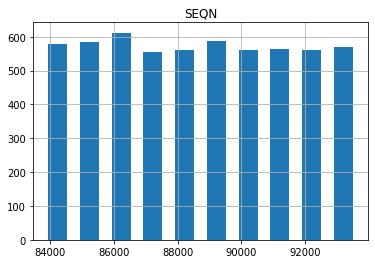

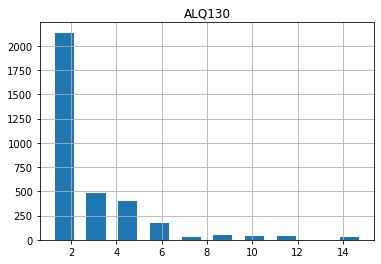

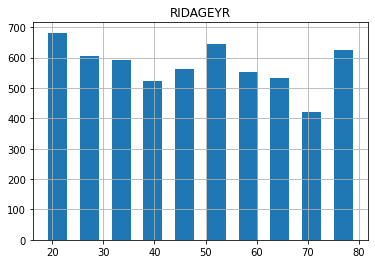

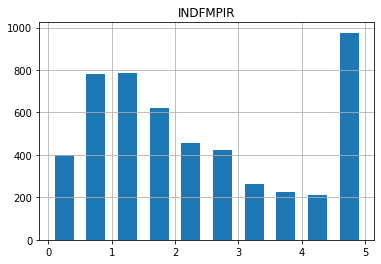

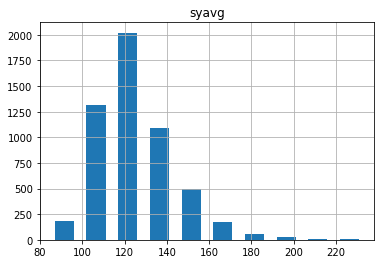

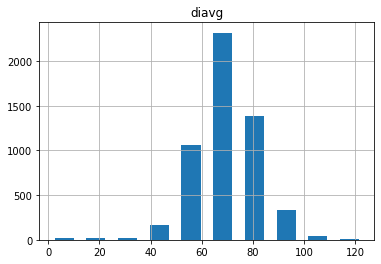

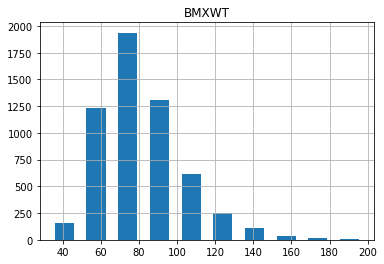

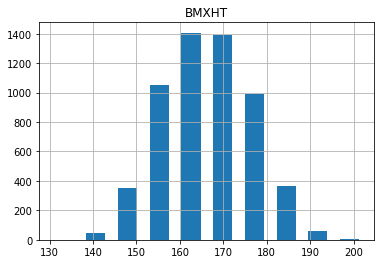

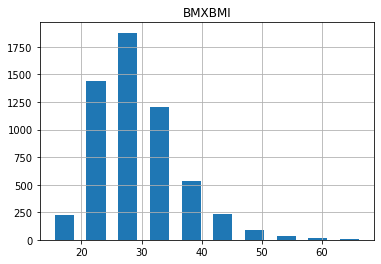

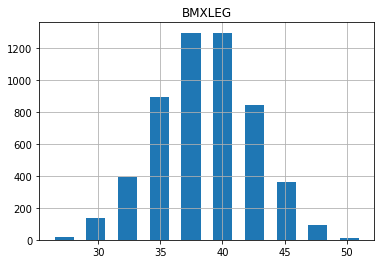

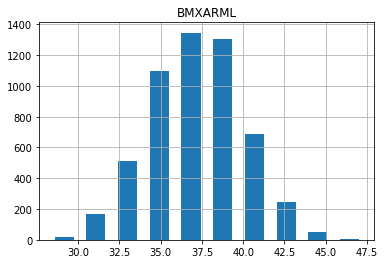

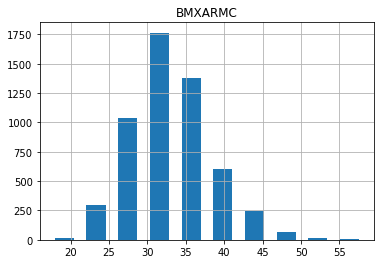

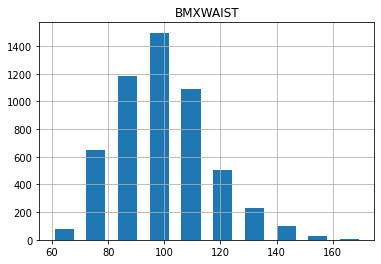

In [179]:
#Quick plots to visualise continuous data distribution 
for col in dfcont.columns: 
    try:      
        dfcont[col] = pd.to_numeric(dfcont[col]) 
        dfcont.hist(column=col,rwidth=.6)
    except ValueError:
        print('This column can not be represented as a histogram')


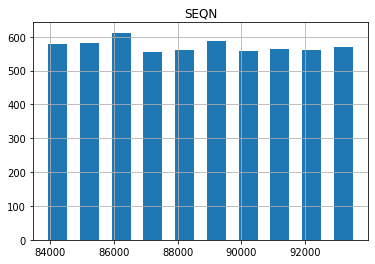

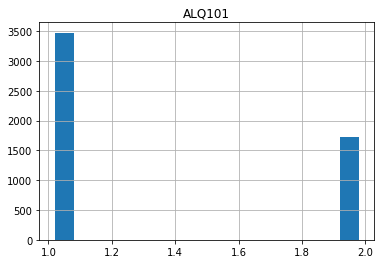

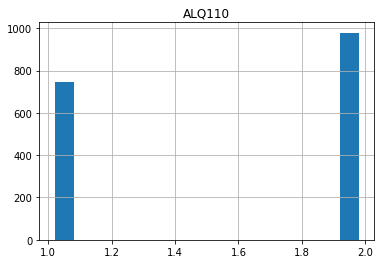

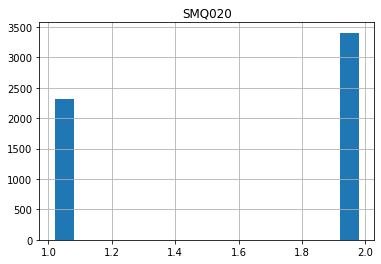

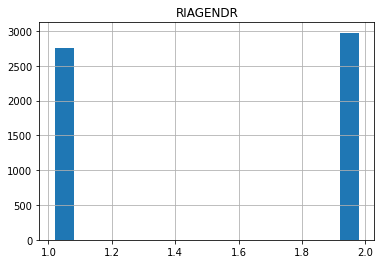

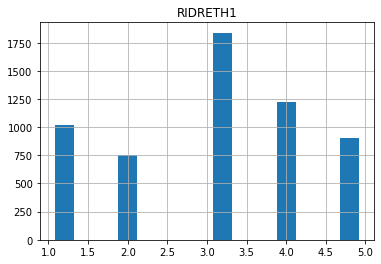

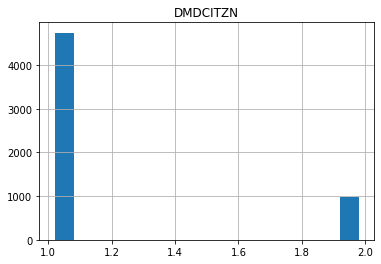

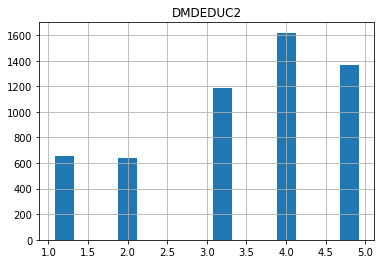

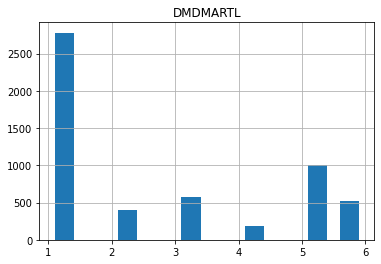

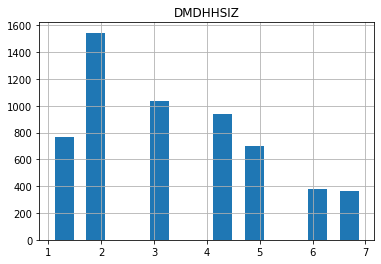

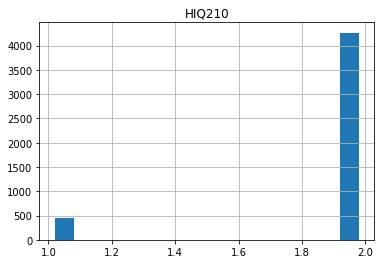

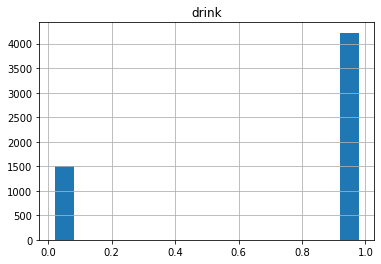

In [180]:
#Quick plots to visualise categorical data distribution
for col in dfcat.columns: 
    try:      
        dfcat[col] = pd.to_numeric(dfcat[col]) 
        dfcat.hist(column=col,rwidth=.6)
    except ValueError:
        print('This column can not be represented as a histogram')

<Figure size 432x288 with 0 Axes>

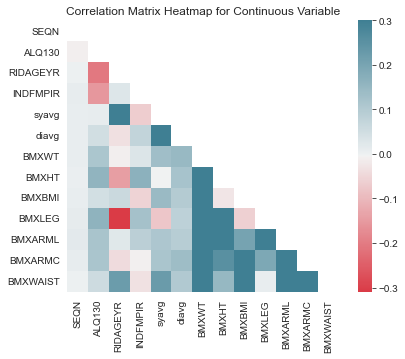

In [185]:
# Correlation matrix for continuous dataset
dfcontcorr = dfcont.corr()


# Plotting of Corr Heatmap
mask = np.zeros_like(dfcont.corr())
mask
mask[np.triu_indices_from(mask)]= True
fig = plt.figure(constrained_layout=True)

with sns.axes_style('white'):
        f, ax = plt.subplots(figsize=(7,5))
        ax = sns.heatmap(dfcont.corr(), mask=mask, vmax =.3, square = True, cmap= sns.diverging_palette(10,220, as_cmap=True))
        plt.title("Correlation Matrix Heatmap for Continuous Variable")
        plt.show()

### Visualising Data Variables
  - Comparing the the differences between Ethnic Groups
    - BMI
    - Height
    - Smoking
    - Drinking
- Explore if Income affects their weight outcome
  - Compare within sample population
  - Compare between each Ethnic group
- Explore if education status affect their weight outcome
  - Compare within sample population
  - Compare between each Ethnic group

#### BMI Comparison Between Ethnic Groups

count    5662.000000
mean       29.382197
std         7.095921
min        14.500000
25%        24.300000
50%        28.300000
75%        33.000000
max        67.300000
Name: BMXBMI, dtype: float64
mode:  0    29.1
dtype: float64
29.1    52
26.5    49
27.8    47
26.8    45
26.9    45
        ..
50.0     1
60.9     1
53.8     1
47.4     1
53.9     1
Name: BMXBMI, Length: 393, dtype: int64


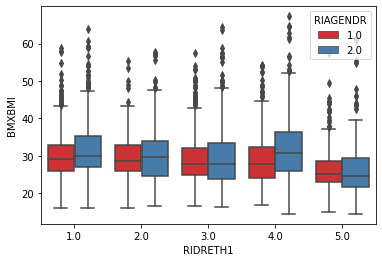

In [215]:
def quantitative_summarized(df, x=None, y=None, hue=None, palette='Set1', ax=None, verbose=True, swarm=False):
    '''
    Helper function that gives a quick summary of quantattive data
    Arguments
    =========
    df: pandas dataframe
    x: str. horizontal axis to plot the labels of categorical data (usually the target variable)
    y: str. vertical axis to plot the quantitative data
    hue: str. if you want to compare it another categorical variable (usually the target variable if x is another variable)
    palette: array-like. Colour of the plot
    swarm: if swarm is set to True, a swarm plot would be overlayed
    Returns
    =======
    Quick Stats of the data and also the box plot of the distribution
    '''
    plt.clf()
    series = df[y]
    print(series.describe())
    print('mode: ', series.mode())
    if verbose:
        print('='*80)
        print(series.value_counts())

    sns.boxplot(x=x, y=y, hue=hue, data=df, palette=palette, ax=ax)

    if swarm:
        sns.swarmplot(x=x, y=y, hue=hue, data=df,
                      palette=palette, ax=ax)

    plt.show()

bmigeneth= pd.concat([dfcat.loc[:,'RIAGENDR'],dfcat.loc[:,'RIDRETH1'],dfcont.loc[:,'BMXBMI']], axis=1)

#Boxplot comparision between gender, ethnic for BMI
quantitative_summarized(bmigeneth, x='RIDRETH1', y='BMXBMI', hue='RIAGENDR')
